Multiclass classification B)

mRNA localization using multiclass classification <br> 
Classes: cytoplasm, endoplasmic reticulum, mitochondira and nucleus <br>
Basic model with: <br> 
<br>
a) Method 1: no feature selection and <br>
b) Method 4: with feature importance-based feature selection (get_feature_importance type (default) =  EFstrType.FeatureImportance), threshold 0 <br>
c) Method 5: with feature importance-based feature selection (feature importance type: SHAP values), threshold > 0

In [1]:
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from catboost import Pool
import shap


In [2]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score, roc_auc_score, precision_recall_curve, roc_curve, f1_score, auc, classification_report

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import plotly.express as px


In [3]:
#Data initialization

all_train = pd.read_csv("../../Data/InputData/all_loc_train.csv")
all_test = pd.read_csv("../../Data/InputData/all_loc_test.csv")

print("TRAINING SET SHAPE:", all_train.shape)
print("TESTING SET SHAPE:", all_test.shape)
# all_train.info()
all_train.head(1122)

TRAINING SET SHAPE: (2040, 1026)
TESTING SET SHAPE: (510, 1026)


,#,label,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,mRNALoc_403#10320|0|training,0,0.003643,0.000792,0.001426,0.002218,0.001584,0.000950,0.000792,0.000950,...,0.000000,0.002693,0.002059,0.001109,0.001109,0.002534,0.001584,0.001901,0.003168,0.003643
1,mRNALoc_4404#20399|0|training,0,0.002914,0.000291,0.000583,0.000291,0.000583,0.000000,0.000000,0.000583,...,0.000583,0.000291,0.000583,0.000291,0.000000,0.001166,0.000291,0.001166,0.000583,0.000291
2,mRNALoc_3392#17196|0|training,0,0.002291,0.001375,0.000458,0.001375,0.000000,0.000917,0.000458,0.001375,...,0.000917,0.001375,0.000917,0.000458,0.000458,0.000917,0.000917,0.002750,0.000458,0.000458
3,mRNALoc_3095#162989|0|training,0,0.000000,0.000990,0.000495,0.000000,0.000990,0.000990,0.000000,0.000495,...,0.000000,0.000495,0.000990,0.000000,0.001484,0.000495,0.000495,0.000000,0.000000,0.000000
4,mRNALoc_1488#117177|0|training,0,0.013061,0.002488,0.004043,0.004354,0.001451,0.001348,0.000415,0.002902,...,0.000311,0.001762,0.001970,0.000933,0.002591,0.001970,0.002695,0.002384,0.002488,0.003732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117,mRNALoc_4037#1951|1|training,1,0.001170,0.000334,0.000334,0.000334,0.000418,0.000167,0.000000,0.000501,...,0.000752,0.000501,0.000919,0.000668,0.000752,0.001170,0.000501,0.000418,0.001086,0.000835
1118,mRNALoc_17428#8029|1|training,1,0.002263,0.001006,0.001090,0.001341,0.001760,0.000922,0.000168,0.001593,...,0.000168,0.001174,0.002012,0.001090,0.000922,0.001760,0.001006,0.001425,0.001257,0.001760
1119,mRNALoc_11450#5362|1|training,1,0.003929,0.001135,0.001572,0.000960,0.001135,0.000786,0.000175,0.000699,...,0.000175,0.001572,0.001746,0.000960,0.001222,0.001222,0.000611,0.000873,0.001484,0.001310
1120,mRNALoc_18600#853213|2|training,2,0.003945,0.001255,0.002690,0.002152,0.001435,0.000359,0.001076,0.001435,...,0.001614,0.001255,0.003407,0.001435,0.001435,0.001973,0.001435,0.001435,0.002869,0.001435


<Axes: >

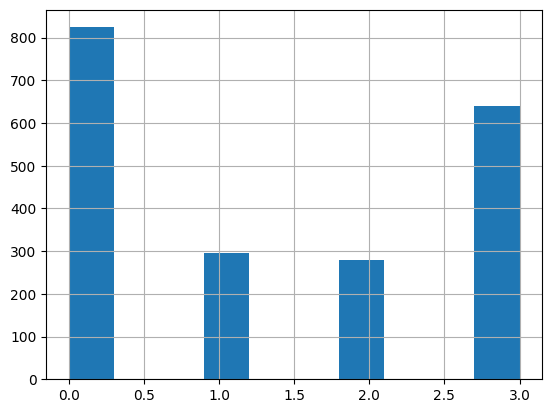

In [4]:
# Remove name/symbol column and separate labels and variables from training set to create X and y sets
# Check distribution of training set

noname_train = all_train.drop("#", axis="columns")

X_train = noname_train.drop("label", axis="columns")
y_train = noname_train["label"]

y_train.hist()

In [5]:
y_train.value_counts()

label
0    824
3    640
1    296
2    280
Name: count, dtype: int64

<Axes: >

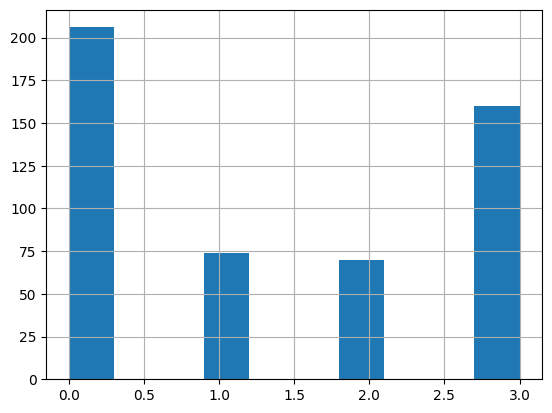

In [6]:
# Remove name/symbol column and separate labels and variables from testing set to create X and y sets
# Check distribution of testing set

noname_test = all_test.drop("#", axis="columns")

X_test = noname_test.drop("label", axis="columns")
y_test = noname_test["label"]

y_test.hist()

In [7]:
# Create data pool for feature importance/selection for full set

ALL_feature_names = list(X_train.columns)
print("Number of features:", len(ALL_feature_names))

ALL_train_pool = Pool(X_train, y_train, feature_names = ALL_feature_names)

ALL_test_pool = Pool(X_test, y_test)

print("Data pool created for full set")


Number of features: 1024
Data pool created for full set


    Method 1: Initial multiclass classification (without feature importance, selection or auto_class_weights)

In [8]:
#Create and fit CatBoost model

model = CatBoostClassifier(loss_function="MultiClass")
model.fit(ALL_train_pool)

#takes 4m 25s to run

Learning rate set to 0.082057
0:	learn: 1.3368905	total: 706ms	remaining: 11m 45s
1:	learn: 1.2932490	total: 1s	remaining: 8m 21s
2:	learn: 1.2555113	total: 1.32s	remaining: 7m 19s
3:	learn: 1.2178813	total: 1.6s	remaining: 6m 38s
4:	learn: 1.1847470	total: 1.94s	remaining: 6m 26s
5:	learn: 1.1555796	total: 2.25s	remaining: 6m 13s
6:	learn: 1.1250596	total: 2.52s	remaining: 5m 57s
7:	learn: 1.1008409	total: 2.79s	remaining: 5m 46s
8:	learn: 1.0775055	total: 3.07s	remaining: 5m 37s
9:	learn: 1.0566143	total: 3.34s	remaining: 5m 30s
10:	learn: 1.0370284	total: 3.61s	remaining: 5m 24s
11:	learn: 1.0163947	total: 3.88s	remaining: 5m 19s
12:	learn: 0.9988997	total: 4.12s	remaining: 5m 13s
13:	learn: 0.9839972	total: 4.41s	remaining: 5m 10s
14:	learn: 0.9655918	total: 4.67s	remaining: 5m 6s
15:	learn: 0.9517768	total: 4.95s	remaining: 5m 4s
16:	learn: 0.9399721	total: 5.2s	remaining: 5m
17:	learn: 0.9259761	total: 5.47s	remaining: 4m 58s
18:	learn: 0.9150924	total: 5.75s	remaining: 4m 57s
19

In [26]:
#Check parameters used in this model fit

multi_FIFS_params = multi_FIFS_model.get_all_params()
print("FIFS model parameters for multiclass classification:", multi_FIFS_params)

FIFS model parameters for multiclass classification: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 1, 2, 3], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'l

In [9]:
#Get multiclass classification prediction using X_test
y_test_pred = model.predict(X_test)

# Prediction probability
y_test_prob = model.predict_proba(X_test)

In [10]:
# Claculate accuracy scores and get classification report

print("Model 1: Basic model - Multiclass")

ALL_cr = classification_report(y_test, y_test_pred, digits=3)
print(ALL_cr)

print("Accuracy score: ", accuracy_score(y_test, y_test_pred))

print("\nROC AUC score : ", roc_auc_score(y_test, y_test_prob, multi_class='ovr'))

ALL_f1 = f1_score(y_test, y_test_pred, average="macro")
print(f"\nF1 Score: {ALL_f1}")

Model 1: Basic model - Multiclass
              precision    recall  f1-score   support

           0      0.565     0.743     0.642       206
           1      0.320     0.108     0.162        74
           2      0.726     0.986     0.836        70
           3      0.403     0.300     0.344       160

    accuracy                          0.545       510
   macro avg      0.504     0.534     0.496       510
weighted avg      0.501     0.545     0.505       510

Accuracy score:  0.5450980392156862

ROC AUC score :  0.7247747330939323

F1 Score: 0.49589381336185967


In [11]:
#create confusion matrix

print("real values shape:", y_test.shape)
print("prediction shape:", y_test_pred.shape)

y_test_pred_fl = y_test_pred
print("flattened prediction values shape:", y_test_pred_fl.ravel().shape, "\n")

cMatrix = confusion_matrix(y_test, y_test_pred_fl)
print(cMatrix)

real values shape: (510,)
prediction shape: (510, 1)
flattened prediction values shape: (510,) 

[[153   1   0  52]
 [ 47   8   0  19]
 [  1   0  69   0]
 [ 70  16  26  48]]


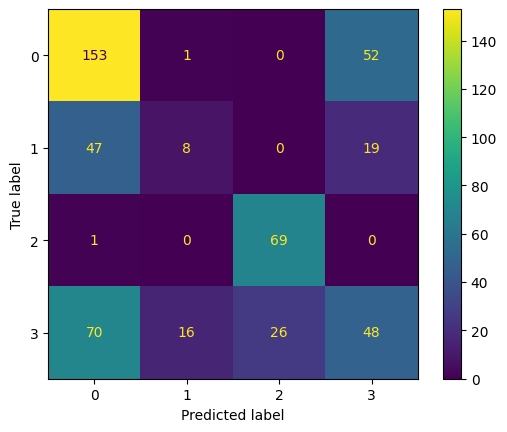

In [12]:
#Confusion matrix using ConfusionMatrixDisplay from sklearn

# predictions = model.predict(X_test)

# cMatrix = confusion_matrix(y_test, predictions, labels=model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cMatrix,display_labels=model.classes_)
disp.plot()
plt.show()

**************

    Method 4: Feature importance-based feature selection with threshold > 0

In [13]:
# Get feature importance values from the basic model

feat_importances = model.get_feature_importance(prettified=True)
feat_importances.head(200)

,Feature Id,Importances
0,CCCCC,1.203203
1,AAAAA,1.132662
2,AGCAG,0.975221
3,TATCG,0.950556
4,GACGA,0.728837
...,...,...
195,CTATC,0.160806
196,CAGAC,0.159888
197,CAATT,0.159825
198,TTCAG,0.159296


In [14]:
# Show only feature importances above 0

threshold_chosen_features = feat_importances[feat_importances['Importances'] > 0]
num_chosen_features = len(threshold_chosen_features)

print(threshold_chosen_features)

print("\nAmount of features with importnace above 0 (selected features):", num_chosen_features)

    Feature Id  Importances
0        CCCCC     1.203203
1        AAAAA     1.132662
2        AGCAG     0.975221
3        TATCG     0.950556
4        GACGA     0.728837
..         ...          ...
988      CGGCA     0.001293
989      CATCA     0.000871
990      GCCTC     0.000625
991      TCGGC     0.000539
992      AGGCC     0.000526

[993 rows x 2 columns]

Amount of features with importnace above 0 (selected features): 993


In [17]:
# Calculate sum of importance values of chosen features 
print("Sum of total feature importances: ", sum(feat_importances.Importances))
print("Sum of feature importances > 0: ", sum(threshold_chosen_features.Importances))

Sum of total feature importances:  100.0
Sum of feature importances > 0:  100.0


In [18]:
#Get only selected features (i.e. with importance values >= 0.1) from X_train

# selected_feat = feat_importances[:349]['Feature Id'].tolist()
selected_feat = feat_importances[:num_chosen_features]['Feature Id'].tolist()
# print(selected_feat)

In [19]:
X_train.tail()

,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
2035,0.004505,0.001855,0.004240,0.004240,0.001855,0.000928,0.000265,0.002385,0.003843,0.002253,...,0.000265,0.002518,0.002120,0.001723,0.001458,0.002253,0.000928,0.002253,0.002518,0.003710
2036,0.003446,0.003048,0.003711,0.002518,0.003711,0.001060,0.001193,0.002253,0.004506,0.002385,...,0.000265,0.001193,0.000928,0.000398,0.000795,0.000663,0.000398,0.000133,0.000928,0.000398
2037,0.001989,0.001061,0.002519,0.002254,0.000663,0.001458,0.000928,0.001193,0.002254,0.002386,...,0.000133,0.001591,0.001458,0.001193,0.001856,0.000928,0.001458,0.000928,0.001591,0.002386
2038,0.003182,0.001193,0.002254,0.000398,0.001326,0.001591,0.000265,0.001326,0.001856,0.001591,...,0.000265,0.000663,0.001856,0.000928,0.000265,0.000398,0.000530,0.000398,0.000663,0.000398
2039,0.010356,0.003054,0.005709,0.004647,0.003850,0.001328,0.000398,0.002390,0.004780,0.001859,...,0.000266,0.003319,0.001593,0.001593,0.002124,0.003585,0.003850,0.002523,0.001726,0.004780


In [20]:
#Create training set with selected features 

X_train_selected = X_train[selected_feat]
X_train_selected.tail()

,CCCCC,AAAAA,AGCAG,TATCG,GACGA,AAGGG,TCGAA,GGGGC,ACGTC,CGAAA,...,GACCG,CTGCG,CGTGC,TGTGG,TTCTA,CGGCA,CATCA,GCCTC,TCGGC,AGGCC
2035,0.000265,0.004505,0.002253,0.000000,0.000000,0.000795,0.000795,0.000000,0.000000,0.000265,...,0.000132,0.000398,0.000132,0.001723,0.001988,0.000265,0.001325,0.000795,0.000132,0.000265
2036,0.000398,0.003446,0.003578,0.000663,0.000928,0.000795,0.000663,0.000530,0.000398,0.000530,...,0.000265,0.000398,0.000133,0.000928,0.001193,0.000133,0.001458,0.000530,0.000133,0.000663
2037,0.001856,0.001989,0.002519,0.000133,0.000398,0.000795,0.000530,0.000265,0.000398,0.000398,...,0.000265,0.000398,0.000398,0.002254,0.000530,0.000133,0.000663,0.000795,0.000133,0.001193
2038,0.001061,0.003182,0.004773,0.000000,0.000796,0.001856,0.000796,0.001061,0.000000,0.000928,...,0.000796,0.000928,0.000398,0.002254,0.000530,0.000530,0.001724,0.002652,0.000398,0.001061
2039,0.000133,0.010356,0.001726,0.000133,0.000266,0.000664,0.000133,0.000531,0.000000,0.000266,...,0.000266,0.000398,0.000000,0.001195,0.002257,0.000398,0.000929,0.000531,0.000266,0.000398


In [21]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(X_train_selected.columns) == selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [22]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", X_train_selected.shape)
print("Shape of y_train (number of labels):", y_train.shape)


Shape of X_train_selected (number of variables/sequences): (2040, 993)
Shape of y_train (number of labels): (2040,)


In [23]:
# Create new pool object with only selected feature data
print("Original number of features:", len(ALL_feature_names), "\n Number of selected features:", len(selected_feat))

selected_train_pool = Pool(X_train_selected, y_train, feature_names=selected_feat)

Original number of features: 1024 
 Number of selected features: 993


In [24]:
#Create new model for data with selected features
multi_FIFS_model = CatBoostClassifier()

# Fit new data into same model as before

multi_FIFS_model.fit(selected_train_pool)

Learning rate set to 0.082057
0:	learn: 1.3395892	total: 399ms	remaining: 6m 38s
1:	learn: 1.2946682	total: 718ms	remaining: 5m 58s
2:	learn: 1.2566761	total: 1.03s	remaining: 5m 42s
3:	learn: 1.2231285	total: 1.33s	remaining: 5m 32s
4:	learn: 1.1927085	total: 1.61s	remaining: 5m 21s
5:	learn: 1.1622961	total: 1.89s	remaining: 5m 12s
6:	learn: 1.1376314	total: 2.17s	remaining: 5m 7s
7:	learn: 1.1118555	total: 2.45s	remaining: 5m 3s
8:	learn: 1.0873013	total: 2.74s	remaining: 5m 2s
9:	learn: 1.0669952	total: 3s	remaining: 4m 57s
10:	learn: 1.0475984	total: 3.27s	remaining: 4m 53s
11:	learn: 1.0308358	total: 3.53s	remaining: 4m 50s
12:	learn: 1.0148428	total: 3.81s	remaining: 4m 48s
13:	learn: 0.9975723	total: 4.06s	remaining: 4m 46s
14:	learn: 0.9838787	total: 4.33s	remaining: 4m 44s
15:	learn: 0.9694199	total: 4.63s	remaining: 4m 45s
16:	learn: 0.9543210	total: 4.91s	remaining: 4m 44s
17:	learn: 0.9389862	total: 5.16s	remaining: 4m 41s
18:	learn: 0.9255937	total: 5.4s	remaining: 4m 38s

In [25]:
#Check parameters used in this model fit

multi_FIFS_params = multi_FIFS_model.get_all_params()
print("FIFS model parameters for multiclass classification:", multi_FIFS_params)

FIFS model parameters for multiclass classification: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 1, 2, 3], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'l

In [27]:
#Prediction using X_test only for selected features data
FIFS_y_pred = multi_FIFS_model.predict(X_test)

#Predication probability for selected features data

FIFS_y_prob = multi_FIFS_model.predict_proba(X_test)

In [28]:
# Calculate F1 score and get classification report

print("Model 4: Feature selection (PredictionValuesChange) w/ threshold > 0 - Multiclass")

print("Number of chosen features:", num_chosen_features, "\n")

FIFS_cr = classification_report(y_test, FIFS_y_pred, digits=3)
print(FIFS_cr)

print('Accuracy score: ', accuracy_score(y_test, FIFS_y_pred))
print('ROC AUC score : ', roc_auc_score(y_test, FIFS_y_prob, multi_class='ovr'))

FIFS_f1 = f1_score(y_test, FIFS_y_pred, average='macro')
print(f"\nF1 Score: {FIFS_f1}")

Model 4: Feature selection (PredictionValuesChange) w/ threshold > 0 - Multiclass
Number of chosen features: 993 

              precision    recall  f1-score   support

           0      0.567     0.743     0.643       206
           1      0.533     0.108     0.180        74
           2      0.711     0.986     0.826        70
           3      0.453     0.362     0.403       160

    accuracy                          0.565       510
   macro avg      0.566     0.550     0.513       510
weighted avg      0.546     0.565     0.526       510

Accuracy score:  0.5647058823529412
ROC AUC score :  0.7291188393118144

F1 Score: 0.5129393767307546


In [29]:
# Confusion matrix for selected data

print("real values shape:", y_test.shape)
print("prediction shape:", FIFS_y_pred.shape)

FIFS_y_pred_fl = FIFS_y_pred
print("flattened prediction values shape:", FIFS_y_pred_fl.ravel().shape, "\n")

FIFS_cMatrix = confusion_matrix(y_test, FIFS_y_pred_fl)
print(FIFS_cMatrix)

real values shape: (510,)
prediction shape: (510, 1)
flattened prediction values shape: (510,) 

[[153   1   0  52]
 [ 48   8   0  18]
 [  1   0  69   0]
 [ 68   6  28  58]]


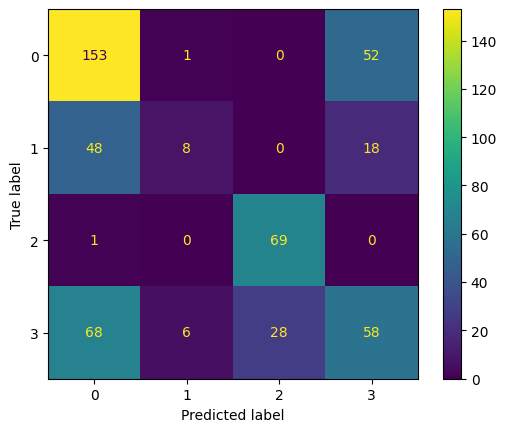

In [30]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=FIFS_cMatrix, display_labels=multi_FIFS_model.classes_)
disp.plot()
plt.show()

*************

    Method 5: Modelling using feature selection based on feature importance values (SHAP Values) with threshold > 0

In [31]:
#SHAP explainer to explain CatBoost output
explainer = shap.TreeExplainer(model)

In [32]:
#SHAP values for X_train
multi_shap_values = explainer.shap_values(X_train)

In [33]:
multi_shap_values[0].shape

(2040, 1024)

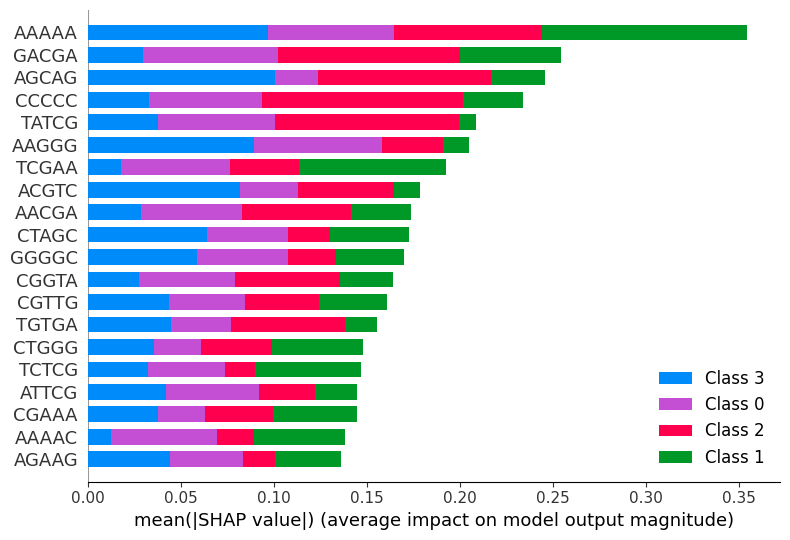

In [34]:
shap.summary_plot(multi_shap_values, X_train, plot_size=0.2, class_names = ["Class 0", "Class 1", "Class 2", "Class 3"])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


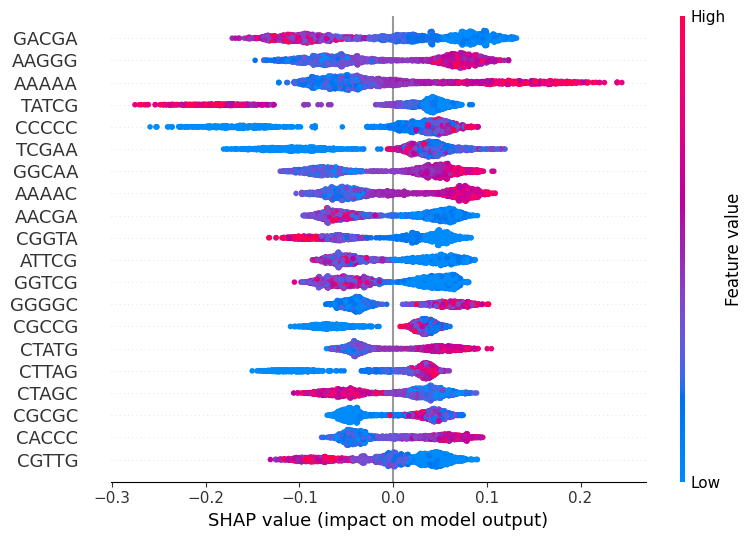

In [35]:
# Summary shap bar plot of Cytoplasm class (class 0)
shap.summary_plot(multi_shap_values[0], X_train, plot_size=0.2)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


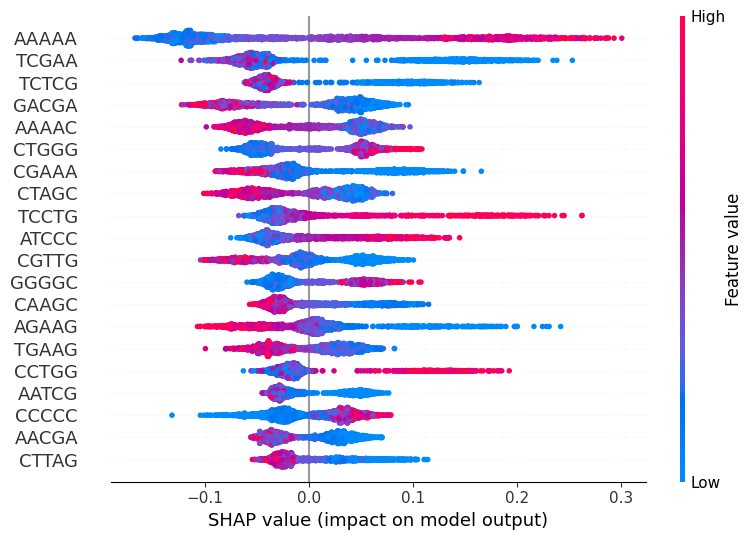

In [36]:
# Summary shap bar plot of Endoplasmic reticuum class (class 1)
shap.summary_plot(multi_shap_values[1], X_train, plot_size=0.2)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


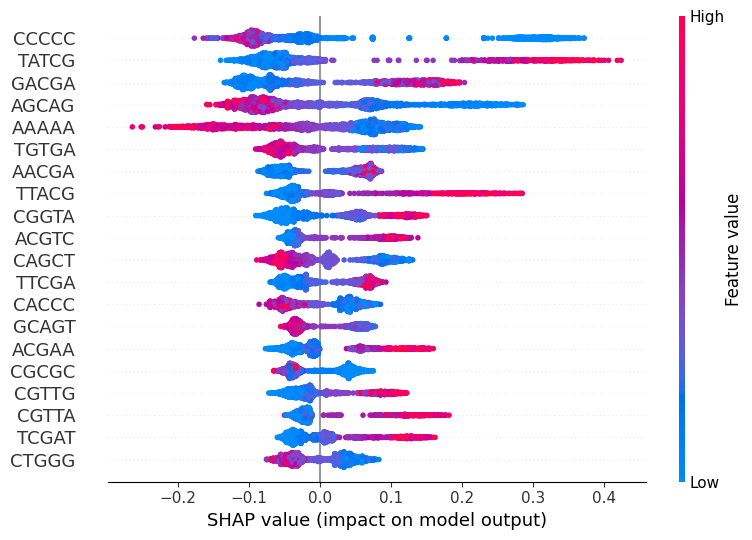

In [37]:
# Summary shap bar plot of mitochondria class (class 2)
shap.summary_plot(multi_shap_values[2], X_train, plot_size=0.2)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


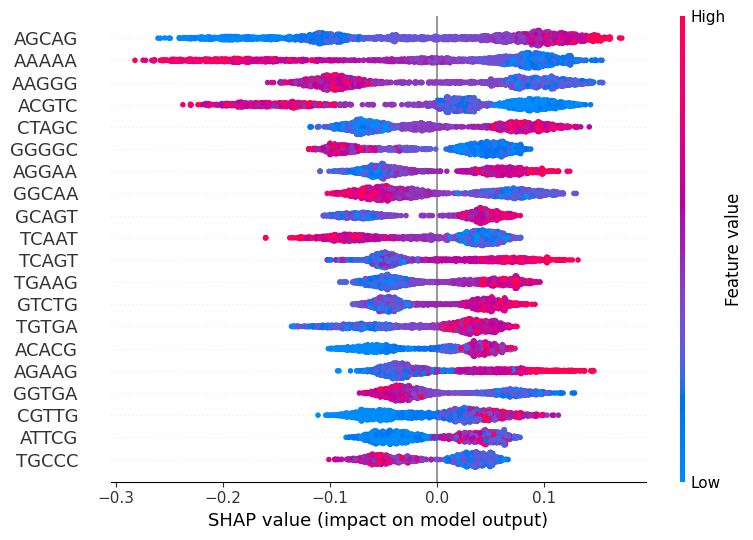

In [38]:
# Summary shap bar plot of nucleus class (class 3)
shap.summary_plot(multi_shap_values[3], X_train, plot_size=0.2)

In [39]:
#Put values one one class into dataframe to use as reference values for FS
shap_df = pd.DataFrame(multi_shap_values[3], columns=X_train.columns)


In [40]:
# Calculate feature importance by only taking the values which 
multi_shap_FI = (shap_df[shap_df>0]
                                .mean()
                                .sort_values(ascending=False)
                                .reset_index()
                                .rename(columns={'index':'Feature Id', 0:'Importances'})
                                # .head()
                        )

In [41]:
multi_shap_FI.head(10)

,Feature Id,Importances
0,AGCAG,0.090256
1,AAGGG,0.087149
2,AAAAA,0.078415
3,CTAGC,0.076747
4,GGCAA,0.070394
5,GGTGA,0.066742
6,TGGCT,0.066131
7,AGGAA,0.063413
8,AGAAG,0.061055
9,TCAGT,0.060503


In [42]:
#Classifier results with CE_feature_importance

In [43]:
from numpy import nansum
print("Sum of all shap feature importance values of class 3:", nansum(multi_shap_FI["Importances"]))

Sum of all shap feature importance values of class 3: 8.339814995491324


In [44]:
# Show only class 3 feature importances above 0

multi_SHAP_thres_chosen = multi_shap_FI[multi_shap_FI['Importances'] > 0]
multi_shap_num_chosen = len(multi_SHAP_thres_chosen)

print(multi_SHAP_thres_chosen)

print("\nAmount of features in class 3 with importance above 0 (selected features):", multi_shap_num_chosen)

    Feature Id  Importances
0        AGCAG     0.090256
1        AAGGG     0.087149
2        AAAAA     0.078415
3        CTAGC     0.076747
4        GGCAA     0.070394
..         ...          ...
988      TATGT     0.000292
989      TTCTA     0.000247
990      GCCTC     0.000221
991      CATCA     0.000215
992      TCGGC     0.000118

[993 rows x 2 columns]

Amount of features in class 3 with importance above 0 (selected features): 993


In [45]:
print("Sum of total feature importances: ", sum(multi_shap_FI.Importances))
print("Sum of feature importances >=0.005: ", sum(multi_SHAP_thres_chosen.Importances))

Sum of total feature importances:  nan
Sum of feature importances >=0.005:  8.339814995491329


In [46]:
# Select features with importance values above 0.005

multi_shap_selected_feat = multi_shap_FI[:multi_shap_num_chosen]['Feature Id'].tolist()

# print(multi_shap_selected_feat)

In [47]:
# See original training set

X_train.head(826)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.003643,0.000792,0.001426,0.002218,0.001584,0.000950,0.000792,0.000950,0.001901,0.001742,...,0.000000,0.002693,0.002059,0.001109,0.001109,0.002534,0.001584,0.001901,0.003168,0.003643
1,0.002914,0.000291,0.000583,0.000291,0.000583,0.000000,0.000000,0.000583,0.000874,0.001457,...,0.000583,0.000291,0.000583,0.000291,0.000000,0.001166,0.000291,0.001166,0.000583,0.000291
2,0.002291,0.001375,0.000458,0.001375,0.000000,0.000917,0.000458,0.001375,0.001375,0.000917,...,0.000917,0.001375,0.000917,0.000458,0.000458,0.000917,0.000917,0.002750,0.000458,0.000458
3,0.000000,0.000990,0.000495,0.000000,0.000990,0.000990,0.000000,0.000495,0.001484,0.000000,...,0.000000,0.000495,0.000990,0.000000,0.001484,0.000495,0.000495,0.000000,0.000000,0.000000
4,0.013061,0.002488,0.004043,0.004354,0.001451,0.001348,0.000415,0.002902,0.003110,0.001244,...,0.000311,0.001762,0.001970,0.000933,0.002591,0.001970,0.002695,0.002384,0.002488,0.003732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,0.004328,0.002331,0.002331,0.002664,0.002997,0.000499,0.000000,0.001665,0.002331,0.002664,...,0.000000,0.002664,0.001998,0.001665,0.001332,0.003329,0.002331,0.001998,0.002664,0.003995
822,0.004830,0.001499,0.002498,0.004997,0.002332,0.001332,0.000333,0.000833,0.001832,0.001166,...,0.000000,0.002498,0.002831,0.001332,0.001832,0.003664,0.006329,0.002998,0.003831,0.008494
823,0.002500,0.000167,0.000500,0.000167,0.000500,0.000667,0.000167,0.000667,0.000667,0.000333,...,0.000167,0.000667,0.001167,0.000167,0.000333,0.000333,0.000333,0.000167,0.000167,0.000500
824,0.004569,0.000962,0.001203,0.003608,0.001924,0.001203,0.000240,0.001924,0.003126,0.002165,...,0.000962,0.000722,0.000722,0.001203,0.001684,0.003126,0.001924,0.001203,0.002405,0.001443


In [48]:
#Create training set with selected features 

multi_X_train_shap_selected = X_train[multi_shap_selected_feat]
multi_X_train_shap_selected.head()

,AGCAG,AAGGG,AAAAA,CTAGC,GGCAA,GGTGA,TGGCT,AGGAA,AGAAG,TCAGT,...,ACTTG,GCCAC,CTGAT,GCGTG,CGTGC,TATGT,TTCTA,GCCTC,CATCA,TCGGC
0,0.002059,0.001267,0.003643,0.000634,0.001426,0.001109,0.001109,0.001742,0.001742,0.001109,...,0.000950,0.001742,0.000634,0.000634,0.000634,0.000792,0.001109,0.001267,0.001109,0.000475
1,0.003788,0.001748,0.002914,0.000583,0.001457,0.001166,0.002331,0.002040,0.004079,0.002040,...,0.000583,0.001166,0.000291,0.000874,0.000583,0.000874,0.000291,0.003497,0.000874,0.000583
2,0.002291,0.002750,0.002291,0.000000,0.000917,0.001375,0.003666,0.001833,0.002291,0.000458,...,0.001375,0.001833,0.000458,0.000458,0.000917,0.001375,0.000917,0.000917,0.000458,0.000917
3,0.003464,0.003464,0.000000,0.000495,0.001484,0.000990,0.000495,0.000495,0.000990,0.001484,...,0.000990,0.002474,0.001484,0.001979,0.000990,0.000495,0.000000,0.001979,0.001484,0.000990
4,0.001762,0.001037,0.013061,0.000311,0.001140,0.001037,0.001659,0.002488,0.001659,0.001555,...,0.002073,0.000622,0.001140,0.000311,0.000622,0.001866,0.001348,0.000104,0.001140,0.000104


In [49]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(multi_X_train_shap_selected.columns) == multi_shap_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [50]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", multi_X_train_shap_selected.shape)
print("Shape of y_train (number of labels):", y_train.shape)

Shape of X_train_selected (number of variables/sequences): (2040, 993)
Shape of y_train (number of labels): (2040,)


In [51]:
# Create pool object for selected feature data
print("Original number of features:", len(ALL_feature_names), "\n Number of selected features:", len(multi_shap_selected_feat))

multi_shap_selected_train_pool = Pool(multi_X_train_shap_selected, y_train, feature_names=multi_shap_selected_feat)

Original number of features: 1024 
 Number of selected features: 993


In [52]:
#Create new model for data with selected features
multi_FIFS_shap_model = CatBoostClassifier(loss_function="MultiClass")

# Fit new data into same model as before

multi_FIFS_shap_model.fit(multi_shap_selected_train_pool)

Learning rate set to 0.082057
0:	learn: 1.3319160	total: 498ms	remaining: 8m 17s
1:	learn: 1.2840331	total: 794ms	remaining: 6m 36s
2:	learn: 1.2450576	total: 1.09s	remaining: 6m 3s
3:	learn: 1.2112150	total: 1.4s	remaining: 5m 48s
4:	learn: 1.1811195	total: 1.65s	remaining: 5m 29s
5:	learn: 1.1555058	total: 1.92s	remaining: 5m 18s
6:	learn: 1.1284528	total: 2.22s	remaining: 5m 15s
7:	learn: 1.1032074	total: 2.54s	remaining: 5m 14s
8:	learn: 1.0826709	total: 2.89s	remaining: 5m 18s
9:	learn: 1.0614734	total: 3.22s	remaining: 5m 18s
10:	learn: 1.0394537	total: 3.6s	remaining: 5m 24s
11:	learn: 1.0195270	total: 3.91s	remaining: 5m 22s
12:	learn: 1.0014699	total: 4.19s	remaining: 5m 17s
13:	learn: 0.9814905	total: 4.53s	remaining: 5m 18s
14:	learn: 0.9683810	total: 4.83s	remaining: 5m 17s
15:	learn: 0.9520575	total: 5.13s	remaining: 5m 15s
16:	learn: 0.9391455	total: 5.45s	remaining: 5m 15s
17:	learn: 0.9274404	total: 5.73s	remaining: 5m 12s
18:	learn: 0.9139458	total: 6.03s	remaining: 5m

In [53]:
#Check parameters used in this model fit

multi_FIFS_shap_params = multi_FIFS_shap_model.get_all_params()
print("Basic model parameters:", multi_FIFS_shap_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 1, 2, 3], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.082056999206

In [54]:
#Prediction using X_test only for selected features data
multi_FIFS_shap_y_pred = multi_FIFS_shap_model.predict(X_test)

#Predication probability for selected features data

multi_FIFS_shap_y_prob = multi_FIFS_shap_model.predict_proba(X_test)

In [55]:
# Calculate F1 score and get classification report

print("Model 5: Feature selection (SHAP) w/ threshold > 0 - Multiclass")

print("Number of chosen features:", len(multi_shap_selected_feat), "\n")

multi_FIFS_shap_cr = classification_report(y_test, multi_FIFS_shap_y_pred, digits=3)
print(multi_FIFS_shap_cr)

print('Accuracy score: ', accuracy_score(y_test, multi_FIFS_shap_y_pred))

multi_FIFS_shap_f1 = f1_score(y_test, multi_FIFS_shap_y_pred, average='macro')
print('ROC AUC score : ', roc_auc_score(y_test, FIFS_y_prob, multi_class='ovr'))
print(f"\nF1 Score: {multi_FIFS_shap_f1}")


Model 5: Feature selection (SHAP) w/ threshold > 0 - Multiclass
Number of chosen features: 993 

              precision    recall  f1-score   support

           0      0.582     0.738     0.651       206
           1      0.258     0.108     0.152        74
           2      0.684     0.957     0.798        70
           3      0.433     0.325     0.371       160

    accuracy                          0.547       510
   macro avg      0.489     0.532     0.493       510
weighted avg      0.502     0.547     0.511       510

Accuracy score:  0.5470588235294118
ROC AUC score :  0.7291188393118144

F1 Score: 0.49309804221474457


In [56]:
# Confusion matrix for selected data

print("real values shape:", y_test.shape)
print("prediction shape:", multi_FIFS_shap_y_pred.shape)

multi_FIFS_shap_y_pred_fl = multi_FIFS_shap_y_pred
print("flattened prediction values shape:", multi_FIFS_shap_y_pred_fl.ravel().shape, "\n")

multi_FIFS_shap_cMatrix = confusion_matrix(y_test, multi_FIFS_shap_y_pred_fl)
print(multi_FIFS_shap_cMatrix)

real values shape: (510,)
prediction shape: (510, 1)
flattened prediction values shape: (510,) 

[[152   2   0  52]
 [ 50   8   0  16]
 [  1   2  67   0]
 [ 58  19  31  52]]


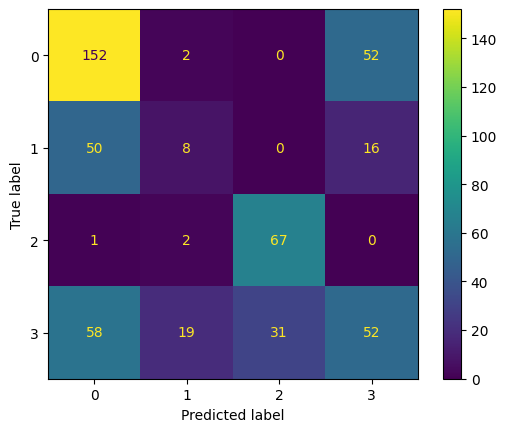

In [57]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=multi_FIFS_shap_cMatrix, display_labels=multi_FIFS_shap_model.classes_)
disp.plot()
plt.show()